In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import nltk
import csv
import networkx as nx
import operator
import matplotlib.pyplot as plt
import pandas as pd
import re

##### loading the data

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

#training_set = np.array(pd.read_csv("paul_my_train.csv").values)
#testing_set = np.array(pd.read_csv("paul_my_test.csv").values)

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(training_set[0][2])

1


##### Graph features computation on authors and articles

##### one might want to add the option of a directed link only if the temporal difference allows us todo so

In [4]:
def graph_articles(citation_set, node_info, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    for node in node_info:
        if node[0] != 'ID':
            #print(int(node[0]))
            G.add_node(int(node[0]), year = node[1])
    for i in citation_set:
        if i[2] == '1':
            if G.node[int(i[0])]['year'] < G.node[int(i[1])]['year']:
                G.add_edge(int(i[0]), int(i[1]))
            else:
                G.add_edge(int(i[1]), int(i[0]))
    return G

In [5]:
def graph_authors(citation_set, node_info, IDs, directed_or_not = 'n'):
    if directed_or_not == 'y':
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    counter = 0
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        if citation[2] == '1':
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_edge(auth1, auth2)
        else:
            for auth1 in source_authors:
                for auth2 in target_authors:
                    G.add_node(auth1)
                    G.add_node(auth2)
               
        counter += 1
    
        if counter % 5000 == True:
            print(counter, "training examples processsed")
    
    return G
    

In [6]:
def compute_page_rank_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    
    pg_rk_features = []
    for citation in citation_set:
        pg_rk_features.append(pg_rk[citation[0]] + pg_rk[citation[1]])
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [7]:
def compute_page_club_feature_for_articles(citation_set, node_info, G=None):
    if G != G:
        G = graph_articles(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    sorted_pgr = sorted(pg_rk.items(), key=operator.itemgetter(1), reverse = True)
    #sp_keys = sorted_pgr.keys()
    sp_keys = [int(a) if a!='ID' else -1 for (a,b) in sorted_pgr]
    #print(sp_keys)
    sp_keys_seen = dict()
    for s in sp_keys:
        sp_keys_seen[s] = False
    
    #nbedgesin = [0]
    
    pageclub = []
    
    in_degs_tuple = list(G.in_degree())
    in_degs = [b for (a,b) in in_degs_tuple]
    k_in = sum(in_degs)/ float(len(in_degs))
    
    n = len(sp_keys)
    
    s=0
    i=1
    kincum=0
    koutcum=0
    
    undirG = G.to_undirected()
    
    for (k,v) in sorted_pgr:
        edges_i = undirG.edges(int(k))
        for (a,b) in edges_i:
            #print(k)
            #print(a,b)
            #print(sp_keys[:i])
            if k!= 'ID':
                if int(a) == int(k):
                    if sp_keys_seen[int(b)]:
                        s+=1
                else:
                    if sp_keys_seen[int(a)]:
                        s+=1        
        if k != 'ID':
            sp_keys_seen[int(k)]= True
        else:
            sp_keys_seen[-1] = True
        kincum += G.in_degree(int(k))
        koutcum += G.out_degree(int(k))
        #print(s)
        if kincum>0 and koutcum >0:
            pageclub.append((s*k_in*n)/(kincum*koutcum))
            G.node[int(k)]['pageclub'] = (s*k_in*n)/(kincum*koutcum)
        else:
            pageclub.append(1)
            G.node[int(k)]['pageclub'] = 1
            
        i+=1
        
    return pageclub
    
    
    
    
    
    

In [8]:
G = graph_articles(training_set, node_info, directed_or_not = 'y')
features = compute_page_club_feature_for_articles(training_set, node_info, G=G)
print(features[:100])

[0.0, 1925.4310344827586, 1580.3066037735848, 1456.6304347826087, 298.0649466192171, 275.5139802631579, 122.45065789473684, 27.072727272727274, 21.32016036655212, 35.29551201011378, 39.563651393481344, 36.79167581814188, 14.473381046325764, 17.99758259468171, 15.152645861601085, 12.525235531628534, 12.06254050550875, 15.859171597633136, 17.30501033057851, 17.03351975595584, 16.618303571428573, 1.3886363106479214, 1.7091577491000811, 1.672517545147116, 1.8161042173840196, 1.8761112329610945, 1.84922660258946, 2.2386239615119052, 2.202759270623302, 2.305615820161622, 2.700852709922061, 2.573975134950745, 2.645133092713738, 2.738407591770678, 2.7101655614771913, 2.693152594989576, 2.75751200439165, 2.733034548582847, 2.820075757575758, 2.905399771187657, 2.8697964112101504, 2.8389746818858255, 2.81908276287037, 3.297423153707824, 3.198252532543679, 3.282909322521772, 3.1983598888772207, 3.1719544408782343, 3.1979741022477, 3.2236004278946564, 3.4502916733236506, 3.6070198714986366, 3.6623

In [8]:
print(len(training_set))

615512


In [9]:
pagerank = nx.pagerank(G)
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
fin_pgr = [b for (a,b) in sorted_pgr]
key_pgr = [int(a) for (a,b) in sorted_pgr]
key_dict = dict()
for i in range(len(key_pgr)):
    key_dict[key_pgr[i]]=i

features[0] = fin_pgr[0]*features[1]/fin_pgr[1]
print(fin_pgr[:10])

[0.001645402097467533, 0.001424760275819383, 0.0010519436046390828, 0.0010472184247037949, 0.0009832450170625929, 0.0009659568864098984, 0.000959639481636504, 0.0009479709775109353, 0.0009160549735749333, 0.0008672857155120708]


In [134]:
fin_pgr[9431]

2.939452061491592e-05

In [135]:
features_edges = []
pagerank_edges = []
for citation in training_set:
        ic0 = key_dict[int(citation[0])]
        ic1 = key_dict[int(citation[1])]
        features_edges.append(G.node[int(citation[0])]['pageclub'] + G.node[int(citation[1])]['pageclub'])
        pagerank_edges.append(fin_pgr[ic0] + fin_pgr[ic1])

In [136]:
print(pagerank_edges[:100])

[4.22919160350594e-05, 5.431943065125116e-05, 3.005054170436466e-05, 6.138795495089078e-05, 0.00018532941497283542, 3.7838285822218675e-05, 3.8269289478376046e-05, 7.897916718930203e-05, 3.9246145449871965e-05, 2.5189206663059247e-05, 6.859360698063235e-05, 7.286225275668309e-05, 9.810022837497762e-05, 4.870104057001872e-05, 2.8129653039589237e-05, 3.771768290630118e-05, 0.00011603746690120207, 7.395111252578146e-05, 0.00014604206073956765, 3.136093978203903e-05, 5.005595839052916e-05, 6.394197867646382e-05, 4.219885360532055e-05, 0.00014586357458201753, 2.5919142255990533e-05, 2.6836984051113248e-05, 6.99559187646048e-05, 6.503792226507927e-05, 5.052368573488053e-05, 0.0001834015283571663, 0.0001028799111382022, 2.8669099544122924e-05, 4.1911741788477024e-05, 5.076706766937614e-05, 0.000129687451087622, 2.8957966970927362e-05, 0.00017887978380697953, 3.4248331137059865e-05, 3.26462371001688e-05, 0.00010728593910280305, 0.0006745973033852901, 3.494700385874316e-05, 5.254248849206105e-0

In [137]:
len(features_edges)

615512

In [138]:
data_test=[]
for i in range(len(pagerank_edges)):
    data_test.append([pagerank_edges[i],features_edges[i]])
print(data_test[:10])

[[4.22919160350594e-05, 2.2669514508568533], [5.431943065125116e-05, 2.5156615491138012], [3.005054170436466e-05, 2.0554095814500912], [6.138795495089078e-05, 2.657530789262343], [0.00018532941497283542, 5.1742994039206875], [3.7838285822218675e-05, 2.1553609449524327], [3.8269289478376046e-05, 2.1958127225332156], [7.897916718930203e-05, 3.1698279761412453], [3.9246145449871965e-05, 2.1766278174480496], [2.5189206663059247e-05, 1.9993175604879485]]


In [139]:
with open("./louis_training_graph_page.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow(a)

In [140]:
key_dict[9510123]

10515

In [141]:
features_edgestest = []
pagerank_edgestest = []
for citation in testing_set:
    if citation[0] != 'ID1':
        #print(citation[0])
        #print(key_dict[int(citation[0])])
        ic0 = key_dict[int(citation[0])]
        #print(ic0)
        #print(citation[1])
        ic1 = key_dict[int(citation[1])]
        
        features_edgestest.append(G.node[int(citation[0])]['pageclub'] + G.node[int(citation[1])]['pageclub'])
        pagerank_edgestest.append(fin_pgr[ic0] + fin_pgr[ic1])

In [142]:
data_test=[]
for i in range(len(pagerank_edgestest)):
    data_test.append([pagerank_edgestest[i],features_edgestest[i]])
print(data_test[:10])

[[3.507178885577559e-05, 2.1207464672129026], [0.0003039574083591652, 5.43131239991166], [2.706417503736724e-05, 2.0111454220008644], [0.0001206130972605893, 4.308429965766756], [6.854480842222834e-05, 2.996618889303336], [8.050351359456964e-05, 3.094118560579257], [2.6197261422090474e-05, 2.0069051743679056], [2.989183162877503e-05, 2.0442718302293623], [8.639223527949365e-05, 3.492295219709246], [3.0389317692587633e-05, 2.049810007230713]]


In [143]:
with open("./louis_testing_graph_page.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["pagerank","pageclub"])
    for a in data_test:
        writer.writerow(a)

### La feature a enregistré est feature_edges au dessus, le reste est des tests et reste du fichier de yannis

In [11]:
print(features[:10])

[2223.6079405323303, 1925.4310344827586, 1580.3066037735848, 1456.6304347826087, 298.0649466192171, 275.5139802631579, 122.45065789473684, 27.072727272727274, 21.32016036655212, 35.29551201011378]


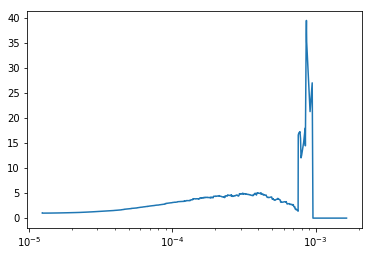

In [13]:
plt.xscale('log')
features[0]=0
features[1]=0
features[2]=0
features[3]=0
features[4]=0
features[5]=0
features[6]=0
plt.plot(fin_pgr,features)
plt.show()

In [138]:
sorted_pgr = sorted(pagerank.items(), key=operator.itemgetter(1), reverse = True)
sp_keys = [float(b) for (a,b) in sorted_pgr]
print(len(sp_keys) != len(set(sp_keys)))

True


In [139]:
print(sp_keys)

[0.00170318373688099, 0.0009298355926681889, 0.0009005276311660342, 0.0008387034133328405, 0.0008361877809952189, 0.0008177063455503618, 0.0008050376334219899, 0.000788382583099261, 0.0007816514287760656, 0.0007743556217864901, 0.000741361038858943, 0.0007322468022830154, 0.0007237932924229044, 0.0007065588590957429, 0.0006901538325716295, 0.0006889834527718087, 0.0006883762470008862, 0.0006749997141879593, 0.0006654647055925303, 0.0006601841682386726, 0.0006470134393397561, 0.0006458085188586262, 0.0006394617423679684, 0.0006372379828555201, 0.0006274635604131289, 0.0006224108423009532, 0.0006098330474289262, 0.0006079070781568649, 0.0006073455483150611, 0.0006031915464318257, 0.0005990387078954609, 0.0005967193607083608, 0.0005967096062280244, 0.0005964674576021343, 0.0005960748071113137, 0.0005898081882260201, 0.0005739681284665157, 0.0005724132005659443, 0.0005648353639742826, 0.0005594226464594777, 0.0005575843566696391, 0.0005558485226841963, 0.0005516236390795198, 0.000542244401

##### beware, they are quite long to compute each

In [3]:
def compute_page_rank_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    pg_rk = nx.pagerank(G)
    pg_rk_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += pg_rk[auth]
        
        pg_rk_features.append(feature)
    
    if bool:
        return np.array(pg_rk_features), G
    else:
        return np.array(pg_rk_features)

In [26]:
def compute_rich_club_feature_for_articles(citation_set, G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    
    rc_cl_features = []
    for citation in citation_set:
        rc_cl_features.append(rc_cl[citation[0]] + rc_cl[citation[1]])
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [25]:
def compute_rich_club_feature_for_authors(citation_set, node_info, G=None):
    if G != G:
        G = graph_authors(citation_set, node_info)
        bool = True
    else:
        bool = False
    
    rc_cl = nx.richclub.rich_club_coefficient(G)
    rc_cl_features = []
    for citation in citation_set:
        source = citation[0]
        target = citation[1]
        
        index_source = IDs.index(source)
        index_target = IDs.index(target)
        
        source_authors = [element[3].split(",") for element in node_info if element[0]==source][0]
        target_authors = [element[3].split(",") for element in node_info if element[0]==target][0]
        
        feature = 0
        for auth in source_authors + target_authors:
            feature += rc_cl[auth]
        
        rc_cl_features.append(feature)
    
    if bool:
        return np.array(rc_cl_features), G
    else:
        return np.array(rc_cl_features)

In [16]:
def compute_shorthest_path_feature_for_articles(citation_set,G=None):
    if G != G:
        G = graph_articles(citation_set)
        bool = True
    else:
        bool = False
    
    sht_pth_features = []
    for citation in citation_set:
        if citation[2] == '1':
            G.remove_edge(citation[0], citation[1])
        sht_pth_features.append(
                nx.shortest_path_length(G,citation[0], citation[1]) if nx.has_path(G, citation[0], citation[1]) else 30)
        if citation[2] == '1':
            G.add_edge(citation[0], citation[1])
    
    if bool:
        return np.array(sht_pth_features), G
    else:
        return np.array(sht_pth_features)